In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py, os
import numpy as np
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from matplotlib import pyplot as plt
import csv
import time
from skimage.measure import compare_ssim 

In [25]:
modtype='UNet'
model_base_path='C:/Users/Ersalina/NeuralComp_G42/saved_params/'+modtype
test_file_path='C:/Users/Ersalina/NC_Final_Assignment/fastMRI/NC2019MRI/test'
train_file_path='C:/Users/Ersalina/NC_Final_Assignment/fastMRI/NC2019MRI/test'
validate_file_path='C:/Users/Ersalina/NC_Final_Assignment/fastMRI/NC2019MRI/test'

In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available

In [22]:
for fname in sorted(os.listdir(model_base_path)):
    print('filename:',fname)

filename: UNet_10.pth
filename: UNet_11.pth
filename: UNet_12.pth
filename: UNet_13.pth
filename: UNet_6.pth
filename: UNet_7.pth
filename: UNet_8.pth
filename: UNet_9.pth


In [23]:
if modtype=='3L-CNN':
    class CNN_3L(nn.Module):
        def __init__(self):
            super(CNN_3L,self).__init__()
            ### Patch Extraction n1=64 c=1 f1=9
            self.block1=nn.Conv2d(1,64,kernel_size=9,padding=2)
            ### Non-Linear Mapping n2=n1=64 f2=1
            self.block2=nn.Conv2d(64,32,kernel_size=1,padding=2)
            ### Image Reconstruction n3=n2=32 f3=5
            self.block3=nn.Conv2d(32,1,kernel_size=5,padding=2)
            self.RELU=nn.ReLU()
        def forward(self,out):
            out=self.block1(out)
            out=self.RELU(out)
            out=self.block2(out)
            out=self.RELU(out)
            out=self.block3(out)
            return out
elif modtype=='4L-CNN':
    class CNN_4L(nn.Module):
        def __init__(self):
            super(CNN_4L,self).__init__()
            ### Patch Extraction n1=64 c=1 f1=9
            self.block1=nn.Conv2d(1,64,kernel_size=9,padding=2)
            ### Non-Linear Mapping n2=n1=64 f2=1
            self.block2=nn.Conv2d(64,64,kernel_size=1,padding=2)
            ### Image Reconstruction n3=n2=32 f3=5
            self.block3=nn.Conv2d(64,32,kernel_size=5,padding=2)
            ### Image Reconstruction n4=n=32 f3=3
            self.block4=nn.Conv2d(32,1,kernel_size=3,padding=1)
            self.RELU=nn.ReLU()
        def forward(self,out):
            out=self.block1(out)
            out=self.RELU(out)
            out=self.block2(out)
            out=self.RELU(out)
            out=self.block3(out)
            out=self.RELU(out)
            out=self.block4(out)
            return out
elif modtype=='UNet' or modtype=='DCGAN':
    class DoubleConv(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        def forward(self, x):
            return self.double_conv(x)

    class Down(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.maxpool_conv = nn.Sequential(
                nn.MaxPool2d(2),
                DoubleConv(in_channels, out_channels)
            )
        def forward(self, x):
            return self.maxpool_conv(x)

    class Up(nn.Module):
        def __init__(self, in_channels, out_channels, bilinear=True):
            super().__init__()
            if bilinear:
                self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            else:
                self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        def forward(self, x1, x2):
            x1 = self.up(x1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
            x = torch.cat([x2, x1], dim=1)
            return self.conv(x)

    class OutConv(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(OutConv, self).__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        def forward(self, x):
            return self.conv(x)

    class UNet(nn.Module):
        def __init__(self, n_channels, n_classes, bilinear=True):
            super(UNet, self).__init__()
            self.n_channels = n_channels
            self.n_classes = n_classes
            self.bilinear = bilinear
            self.inc = DoubleConv(n_channels, 64)
            self.down1 = Down(64, 128)
            self.down2 = Down(128, 256)
            self.down3 = Down(256, 512)
            self.down4 = Down(512, 512)
            self.up1 = Up(1024, 256, bilinear)
            self.up2 = Up(512, 128, bilinear)
            self.up3 = Up(256, 64, bilinear)
            self.up4 = Up(128, 64, bilinear)
            self.outc = OutConv(64, n_classes)
        def forward(self, x):
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
            return logits
        
    class Generator(nn.Module):
        def __init__(self, n_channels, n_classes, bilinear=True):
            super(Generator, self).__init__()
            self.n_channels = n_channels
            self.n_classes = n_classes
            self.bilinear = bilinear
            self.inc = DoubleConv(n_channels, 64)
            self.down1 = Down(64, 128)
            self.down2 = Down(128, 256)
            self.down3 = Down(256, 512)
            self.down4 = Down(512, 512)
            self.up1 = Up(1024, 256, bilinear)
            self.up2 = Up(512, 128, bilinear)
            self.up3 = Up(256, 64, bilinear)
            self.up4 = Up(128, 64, bilinear) 
            self.outc = OutConv(64, n_classes)
        def forward(self, x):
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
            return logits
        
    class Discriminator(nn.Module):
        def __init__(self, ngpu):
            super(Discriminator, self).__init__()
            self.ngpu = ngpu
            self.main = nn.Sequential(
                # input is (nc) x 64 x 64
                nn.Conv2d(nc, ndf, 4, 3, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                # state size. (ndf) x 32 x 32
                nn.Conv2d(ndf, ndf * 2, 4, 3, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 16 x 16
                nn.Conv2d(ndf * 2, ndf * 4, 4, 3, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 8 x 8
                nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 0, bias=False),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*8) x 4 x 4
                nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
                nn.Sigmoid()
            )

        def forward(self, input):
            return self.main(input)

filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


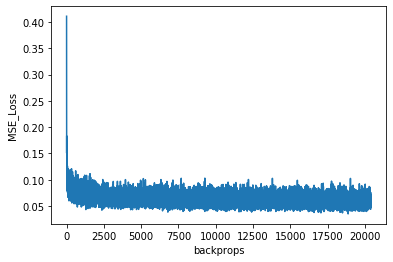

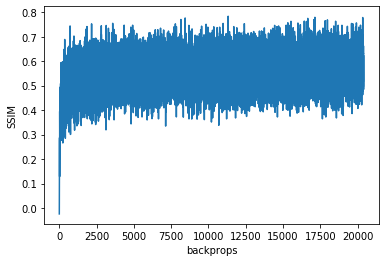

Mean of MSE: 0.06335573524127111
Mean of SSIM: 0.5584360024135734
filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


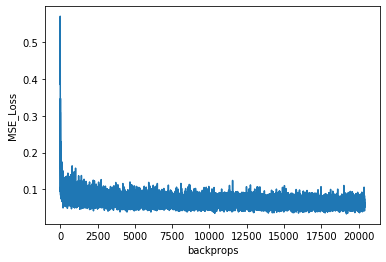

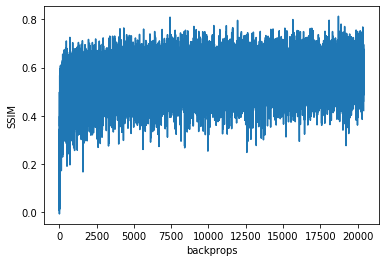

Mean of MSE: 0.06513164756801344
Mean of SSIM: 0.559401083243627
filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


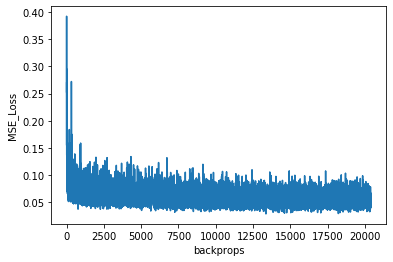

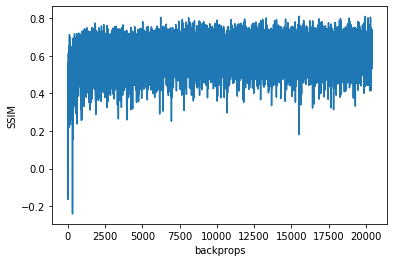

Mean of MSE: 0.06050699718123046
Mean of SSIM: 0.6129944940324442
filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


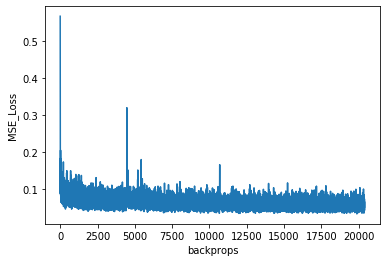

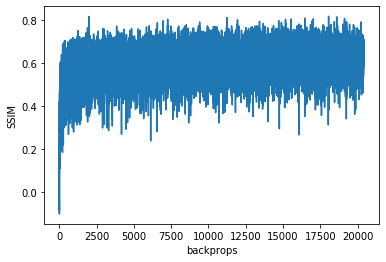

Mean of MSE: 0.06110993558942687
Mean of SSIM: 0.6103753747295262
filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


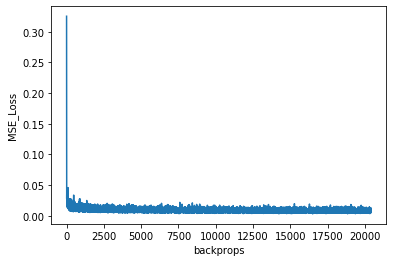

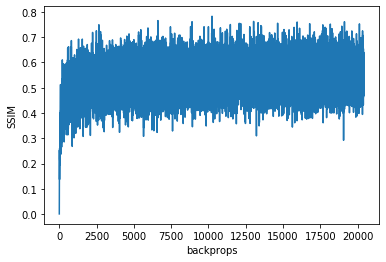

Mean of MSE: 0.008754984470467795
Mean of SSIM: 0.5405837466012238
filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


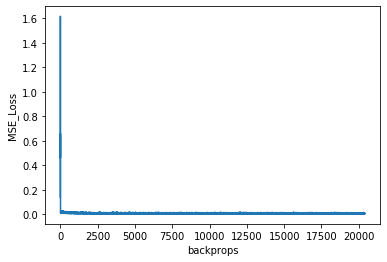

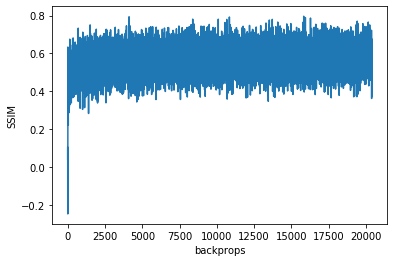

Mean of MSE: 0.007875714503564215
Mean of SSIM: 0.5658420415880632
filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


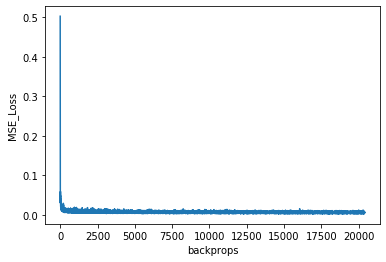

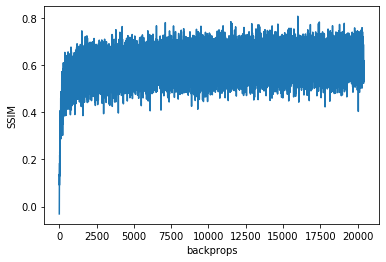

Mean of MSE: 0.00653011038051416
Mean of SSIM: 0.6003348502341831
filepath: C:/Users/Ersalina/NeuralComp_G42/saved_params/UNet


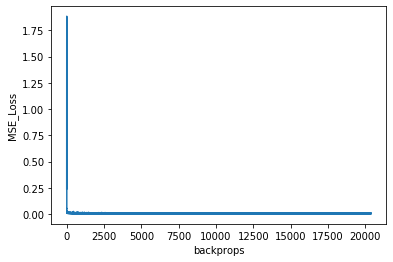

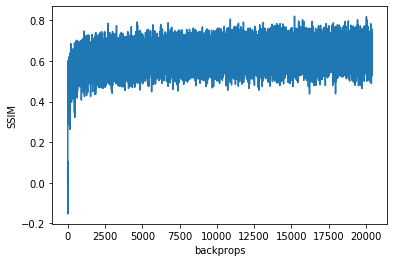

Mean of MSE: 0.0061756383712339566
Mean of SSIM: 0.6272945509244839


In [24]:
model_base_path='C:/Users/Ersalina/NeuralComp_G42/saved_params/'+modtype
lr=1e-2
for fname in sorted(os.listdir(model_base_path)):
    #print('filename:',fname)
    model_base_path='C:/Users/Ersalina/NeuralComp_G42/saved_params/'+modtype
    print('filepath:',model_base_path)
    model_base_path='C:/Users/Ersalina/NeuralComp_G42/saved_params/'+modtype+'/'+fname
    
    if modtype=='3L-CNN':
        model=CNN_3L()
        optimiser = optim.SGD(model.parameters(), lr=lr)
        checkpoint=(torch.load(model_base_path,map_location=device))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
        losses=checkpoint['Loss']
        SSIMval=checkpoint['SSIM']
        
    elif modtype=='4L-CNN':
        model=CNN_4L()
        optimiser = optim.SGD(model.parameters(), lr=lr)
        checkpoint=(torch.load(model_base_path,map_location=device))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
        losses=checkpoint['Loss']
        SSIMval=checkpoint['SSIM']
    elif modtype=='UNet':
        model=UNet(1,1)
        optimiser = optim.SGD(model.parameters(), lr=lr)
        checkpoint=(torch.load(model_base_path,map_location=device))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
        losses=checkpoint['Loss']
        SSIMval=checkpoint['SSIM']
    else:
        netG=Generator(1,1)
        checkpointG=(torch.load(model_path_G,map_location=device))
        netG.load_state_dict(checkpointG['model_state_dict'])
        optimiser.load_state_dict(checkpointG['optimiser_state_dict'])
        G_losses=checkpoint['Loss']
        netD=Discriminator()
        checkpointD=(torch.load(model_path_D,map_location=device))
        netD.load_state_dict(checkpointD['model_state_dict'])
        optimiser.load_state_dict(checkpointD['optimiser_state_dict'])
        D_losses=checkpoint['Loss']


    if modtype=='DCGAN':
        plt.plot(range(len(losses)),losses,label="Training loss")
        plt.xlabel("backprops")
        plt.ylabel("MSE_Loss")
        plt.show()
        plt.plot(range(len(SSIMval)),SSIMval,label="SSIM loss")
        plt.xlabel("backprops")
        plt.ylabel("SSIM")
        plt.show()
        print(sec,'seconds#',int(sec/60),'minutes#')
    else:
        plt.plot(range(len(losses)),losses,label="Training loss")
        plt.xlabel("backprops")
        plt.ylabel("MSE_Loss")
        plt.show()
        plt.plot(range(len(SSIMval)),SSIMval,label="SSIM loss")
        plt.xlabel("backprops")
        plt.ylabel("SSIM")
        plt.show()
        #print(sec,'seconds#',int(sec/60),'minutes#')
        print('Mean of MSE:', np.mean(losses))
        print('Mean of SSIM:', np.mean(SSIMval))

# SSIM calculation

In [ ]:
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )
# compare training and validation dataset with the ground truth
# training SSIM
for tfname in sorted(os.listdir(train_file_path)):
    with h5py.File(train_file_path+'/'+tfname,  "r") as hf:
        # compute baseline SSIM from undersampled image
        
        # compute reconstructed SSIM from network
        
# validate SSIM
for vfname in sorted(os.listdir(validate_file_path)):
    with h5py.File(train_file_path+'/'+vfname,  "r") as hf:
        # compute baseline SSIM from undersampled image
        
        # compute reconstructed SSIM from network
        

# INFERENCE

In [30]:
def kspace2real(data):
    return T.complex_abs(T.ifft2(T.to_tensor(data)))
for tfname in sorted(os.listdir(test_file_path)):
    with h5py.File(test_file_path+'/'+tfname,  "r") as hf:
        volume_kspace_4af = hf['kspace_4af'][()]
        volume_kspace_8af = hf['kspace_8af'][()]
        #print(f'{tfname} 4af 8af',volume_kspace_4af.shape, volume_kspace_8af.shape)
        inp=kspace2real(volume_kspace_4af)
        inp2=kspace2real(volume_kspace_8af)
        Shape=inp.shape
        print(Shape)
        inp_und=inp.view(Shape[0],1,Shape[1],Shape[2])
        inp_und2=inp2.view(Shape[0],1,Shape[1],Shape[2])
        print('s2:',inp_und.shape)
        # Reconstruct the Image by passing undersampled image to the Network
        #IR_4af=model(inp)
        #IR_8af=model(inp)
        hf=h5py.File(tfname+'_recon_'+modtype,'w')
        hf.create_dataset('recon_kspace_4af', data=IR_4af)
        hf.create_dataset('recon_kspace_8af', data=IR_8af)
'''
fig = plt.figure(figsize=(15,10))
plt.imshow(inp[5][0], cmap='gray')
plt.axis('off')
'''

torch.Size([33, 640, 372])
s2: torch.Size([33, 1, 640, 372])


"\nfig = plt.figure(figsize=(15,10))\nplt.imshow(inp[5][0], cmap='gray')\nplt.axis('off')\n"